In [1]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("analysis") \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

spark.sql("USE obligatorio")
spark.sql("SHOW tables").show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2024-12-07T22:03:05,922 WARN [Thread-4] org.apache.hadoop.util.NativeCodeLoader - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-12-07T22:03:07,684 WARN [Thread-4] org.apache.spark.util.Utils - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-12-07T22:03:15,207 INFO [Thread-4] org.apache.hadoop.hive.conf.HiveConf - Found configuration file file:/home/ort/spark/conf/hive-site.xml
2024-12-07T22:03:15,463 WARN [Thread-4] org.apache.hadoop.hive.conf.HiveConf - HiveConf of name hive.metastore.wm.default.pool.size does not exist
2024-12-07T22:03:15,463 WARN [Thread-4] org.apache.hadoop.hive.conf.HiveConf - HiveConf of name hive.llap.task.scheduler.preempt.independent does not exist
2024-12-07T22:03:15,464 WARN [Thread-4] org.apache.hadoop.hive.conf.HiveConf - HiveConf of name hive.llap.output.format.arrow does not exist
2024-12-07T22:03:15,464 WARN [Thread-4] org.apache.hadoop.hive.conf.HiveConf - HiveConf o

+-----------+-------------+-----------+
|  namespace|    tableName|isTemporary|
+-----------+-------------+-----------+
|obligatorio|     cruceros|      false|
|obligatorio|      emisivo|      false|
|obligatorio|       gastos|      false|
|obligatorio|nivel_estudio|      false|
|obligatorio|       paises|      false|
|obligatorio|    receptivo|      false|
+-----------+-------------+-----------+



## Gráfica de turismo emisivo y receptivo en años

La idea de esta grafica es comparar la cantidad de personas que viajaron por año, dividiéndolos en turismo receptivo y emisivo.

Lo primero que hicimos fue sumar la cantidad de gente que viajo por año en Receptivo.

In [4]:
receptivo = spark.sql(""" 
select year(fecha_ingreso) as anio, 
sum(gente) as total_receptivo 
from receptivo 
group by year(fecha_ingreso) 
order by anio 
""")

Luego hicimos lo mismo pero en Emisivo.

In [5]:
emisivo = spark.sql(""" 
select year(fecha_salida) as anio, 
sum(gente) as total_emisivo 
from emisivo 
group by year(fecha_salida) 
order by anio 
""")

Instalamos lo necesario para graficar.

In [24]:
%pip install --user pandas


Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install --user matplotlib

Note: you may need to restart the kernel to use updated packages.


Tomamos las sumas de personas por año que conseguimos en emisivo y receptivo, y los graficamos.

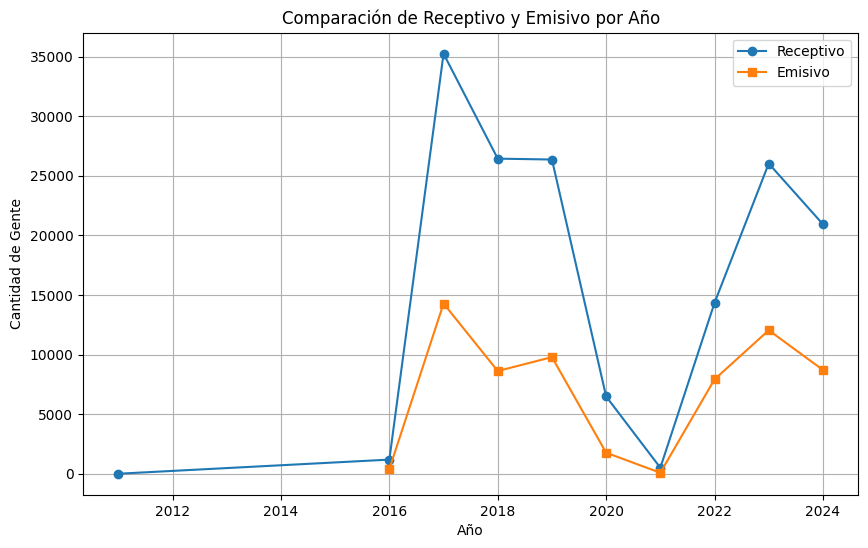

In [6]:
import pandas
combined = receptivo.join(emisivo, "anio", "outer").orderBy("anio")
combined_pd = combined.toPandas()

import matplotlib.pyplot as plt
 
plt.figure(figsize=(10, 6))
plt.plot(combined_pd['anio'], combined_pd['total_receptivo'], marker='o', label='Receptivo')
plt.plot(combined_pd['anio'], combined_pd['total_emisivo'], marker='s', label='Emisivo')
 
plt.title('Comparación de Receptivo y Emisivo por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Gente')
plt.legend()
plt.grid()
plt.show()

## Meses del año donde se hacen más viajes

En este caso, queremos visualizar en que meses del año es cuando mas viaja la gente.

In [7]:
receptivo = spark.sql(""" 
select month(fecha_ingreso) as month, 
sum(gente) as total_receptivo 
from receptivo 
group by month(fecha_ingreso) 
order by month 
""")

In [8]:
emisivo = spark.sql(""" 
select month(fecha_salida) as month, 
sum(gente) as total_emisivo 
from emisivo 
group by month(fecha_salida) 
order by month 
""")

In [9]:
cruceros = spark.sql(""" 
select month(fecha) as month, 
sum(total_personas) as total_cruceros 
from cruceros 
group by month(fecha) 
order by month 
""")

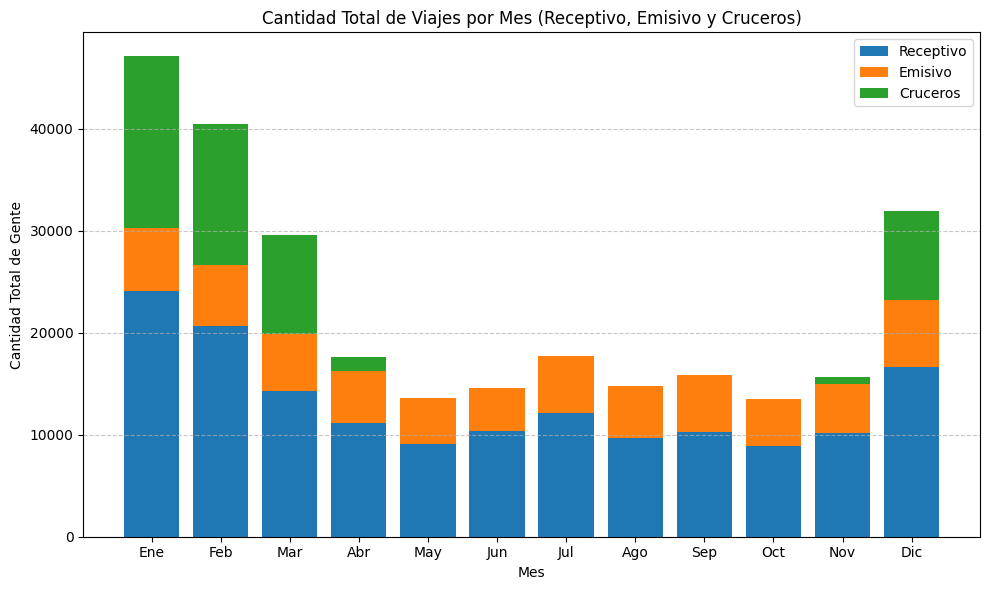

In [10]:
import pandas
combined = receptivo.join(emisivo, "month", "outer").join(cruceros, "month", "outer").orderBy("month")
combined_pd = combined.toPandas()

import matplotlib.pyplot as plt
 
plt.figure(figsize=(10, 6))
 
plt.bar(combined_pd['month'], combined_pd['total_receptivo'], label='Receptivo')
plt.bar(combined_pd['month'], combined_pd['total_emisivo'], bottom=combined_pd['total_receptivo'], label='Emisivo')
plt.bar(combined_pd['month'], combined_pd['total_cruceros'], bottom=combined_pd['total_receptivo'] + combined_pd['total_emisivo'], label='Cruceros')
 
plt.title('Cantidad Total de Viajes por Mes (Receptivo, Emisivo y Cruceros)')
plt.xlabel('Mes')
plt.ylabel('Cantidad Total de Gente')
plt.xticks(combined_pd['month'], labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
 
plt.tight_layout()
plt.show()

## Mapa calor de gastos del turismo receptivo

In [17]:
promedio_gasto_por_pais = spark.sql("""    
SELECT         
p.code AS code,        
AVG(r.gasto_total) AS promedio_gasto    
FROM receptivo r    
JOIN paises p        
ON r.pais = p.pais    
WHERE r.gasto_total IS NOT NULL
AND TRIM(p.code) <> ''
GROUP BY p.code 
ORDER BY promedio_gasto DESC
""")

In [22]:
%pip install --user folium

     |████████████████████████████████| 112kB 20.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import requests
from io import BytesIO

promedio_gasto_pandas = promedio_gasto_por_pais.toPandas()

geojson_url = "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"

response = requests.get(geojson_url, headers={"User-Agent": "Mozilla/5.0"})
response.raise_for_status()

geo_data = gpd.read_file(BytesIO(response.content))

geo_data = geo_data.merge(
    promedio_gasto_pandas,
    left_on="iso_a3",
    right_on="code",
    how="left"
)


m = folium.Map(location=(30, 10), zoom_start=3, tiles="cartodb positron")

folium.Choropleth(
    geo_data=geo_data,
    data=promedio_gasto_pandas,
    columns=["code", "promedio_gasto"],
    key_on="feature.properties.iso_a3",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Promedio de Gasto",
).add_to(m)

geojson = folium.GeoJson(
    geo_data,
    style_function=lambda x: {
        "fillColor": "transparent",
        "color": "transparent",
        "weight": 0.5,
        "fillOpacity": 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "promedio_gasto"],
        aliases=["País", "Promedio de Gasto"],
        localize=True,
    )
).add_to(m)

m

In [42]:
gastos = spark.sql("""
select gasto_total as gasto, fecha_ingreso as fecha, 'Receptivo' AS tipo
from receptivo 
where fecha_ingreso is not null
union all
select gasto_total as gasto, fecha_salida as fecha, 'Emisivo' AS tipo
from emisivo 
""");

gastos.write \
    .mode("overwrite") \
    .option("delimiter", "|") \
    .option("header", "false") \
    .csv("/obligatorio/anl/gastos")

In [43]:
nivel_estudio = spark.sql("""
select estudio as estudio, 'Receptivo' AS tipo
from receptivo 
where fecha_ingreso is not null
union all
select estudio as estudio, 'Emisivo' AS tipo
from emisivo 
""").show()

+--------------------+---------+
|             estudio|     tipo|
+--------------------+---------+
| Secundaria completa|Receptivo|
|  Terciaria completa|Receptivo|
|  Terciaria completa|Receptivo|
| Secundaria completa|Receptivo|
|  Terciaria completa|Receptivo|
|  Terciaria completa|Receptivo|
| Secundaria completa|Receptivo|
|  Terciaria completa|Receptivo|
|Terciaria incompleta|Receptivo|
|  Terciaria completa|Receptivo|
|  Terciaria completa|Receptivo|
|  Terciaria completa|Receptivo|
|Terciaria incompleta|Receptivo|
| Secundaria completa|Receptivo|
|  Terciaria completa|Receptivo|
|Terciaria incompleta|Receptivo|
|Terciaria incompleta|Receptivo|
|  Terciaria completa|Receptivo|
|Terciaria incompleta|Receptivo|
|Terciaria incompleta|Receptivo|
+--------------------+---------+
only showing top 20 rows



In [47]:
nivel_estudio = spark.sql("""
select estudio as estudio, 'Receptivo' AS tipo
from receptivo 
where fecha_ingreso is not null
union all
select estudio as estudio, 'Emisivo' AS tipo
from emisivo 
""");

nivel_estudio.write \
    .mode("overwrite") \
    .option("delimiter", "|") \
    .option("header", "false") \
    .csv("/obligatorio/anl/nivel_estudio")